In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import mcmc_aux

import jsm_prephalo, jsm_stats
from scipy.stats import ks_2samp, anderson_ksamp


In [3]:
def MCMC_RUN(theta_0, lnprob, nwalkers=500, niter=500, ndim=3, ncores=8, converge=False):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        sampler.run_mcmc(p0, niter)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} seconds".format(multi_time))

    if converge==True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

    return sampler

creating the mock SAGA survey

In [4]:
data = mcmc_aux.mock_SAGA_survey([1.9,0.2,0.6], SAGA_ind=12)
data.get_stats(min_mass=6.5)

now workind on the models

In [5]:
def forward(theta):
    models = mcmc_aux.satgen_models(theta, data.lgMh)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax

def lnL_Pnsat(model, data):
    lnL = np.sum(np.log(model[data]))
    if np.isnan(lnL):
        return -np.inf
    else:
        return lnL
    
def lnL_KS(model, data):
    return np.log(ks_2samp(model, data)[1])

def lnlike(theta):
    model_Pnsat, models_Msmax = forward(theta)
    lnL_sat = lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    alpha, delta, sigma = theta
    if 1 < alpha < 3 and -1 < delta < 2 and 0 < sigma < 3:
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

In [6]:
start_theta = [1.6,0.2,1] # a somewhat random starting place

mcmc_out = MCMC_RUN(start_theta, lnprob)
run = mcmc_aux.inspect_run(mcmc_out, fid_theta=data.fid_theta)

Run took 1266.7 seconds


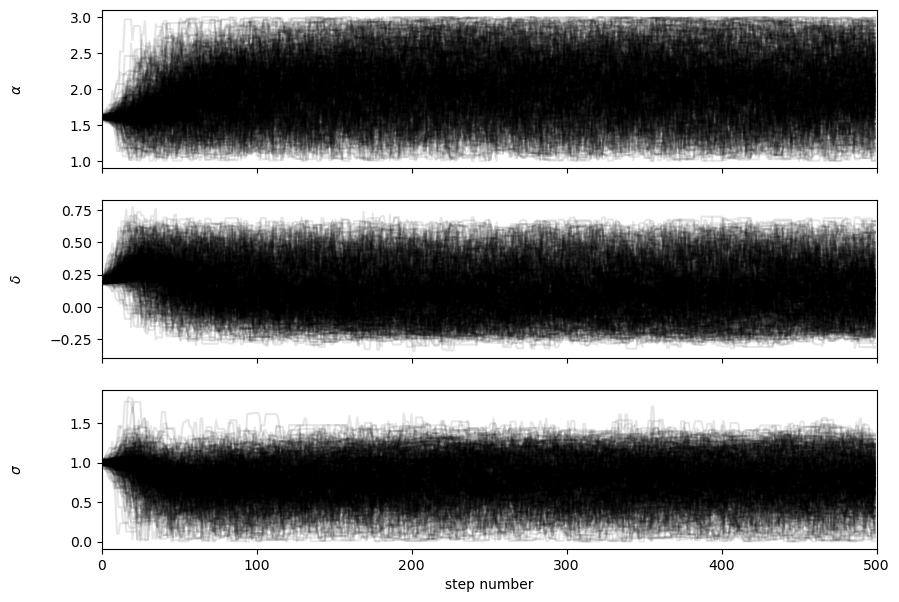

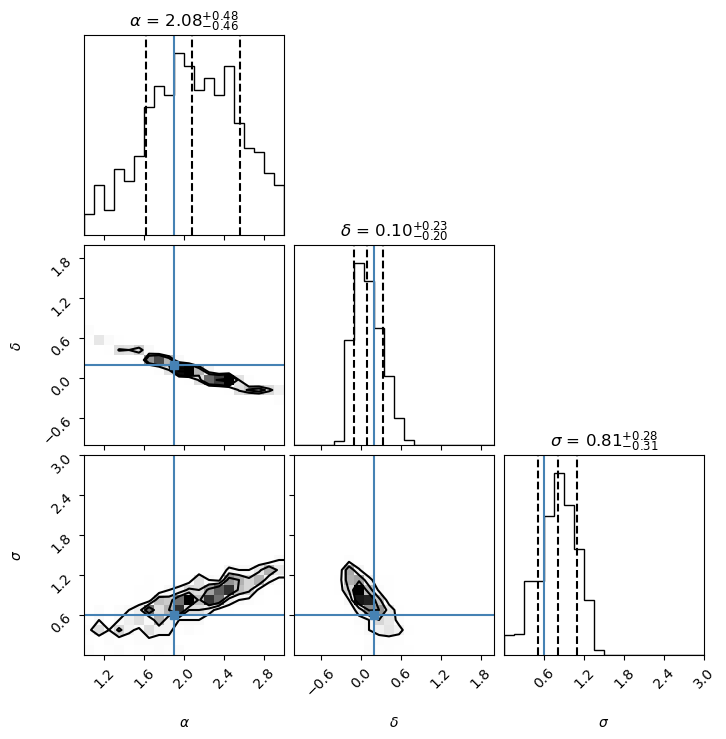

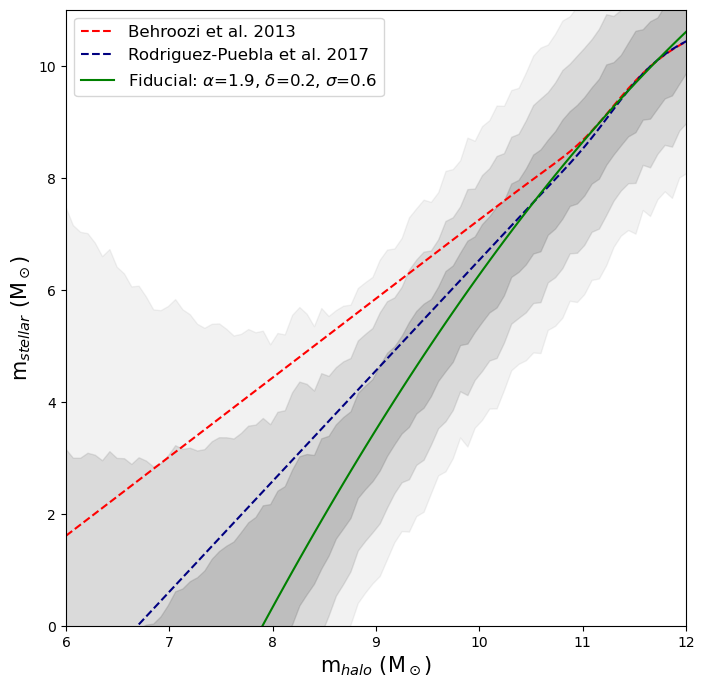

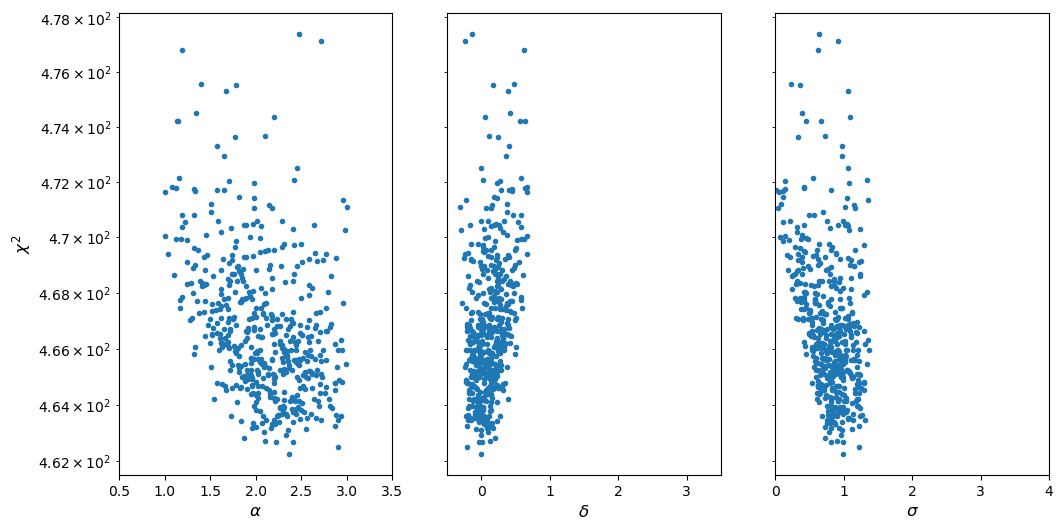

In [7]:
run.chain_plot()
run.corner_plot()
run.SHMR_plot()
run.chi_square_plot()